In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids
import config as C
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
# data
ds = UserJoin()


In [10]:
month = ds.month[C.month_features + ['IS_FLAG', 'label']]
print("month 训练用不到的", C.filter_features(month.columns, t='month'))
print(list(month.columns))

# day = ds.day[C.day_features]
# print("day 训练用不到的", C.filter_features(day.columns, t="day"))
# print(list(day.columns))

# user = ds.train[C.user_features + C.holiday_features]
user = ds.train[C.user_features]
tmp_drop = ['kwh_cal',
            'kwh_pap_r2',
            'kwh_pap_r3',
            'kwh_pap_r4',
            'pr2',
            'pr3',
            'pr4',
            '2_3',
            '2_4',
            '3_4',
            'daycv']
user = user.drop(columns=tmp_drop)
print("user 训练用不到的", C.filter_features(user.columns, t="user"))
print(([i for i in user.columns if 'holiday' not in i]))
# 暂时用不上日的。拼上来的数据值都一样，难做处理。


month 训练用不到的 []
['pq_f', 'pq_g', 'pq_p', 'pq_z', 'pf', 'pp', 'pg', 'p_f', 'p_g', 'f_g', 'monthcv', 'IS_FLAG', 'label']
user 训练用不到的 []
['pq_f', 'pq_g', 'pq_p', 'pq_z', 'pp', 'pf', 'pg', 'p_f', 'p_g', 'f_g', 'monthcv']


In [26]:
# origin month
# month mean
# day mean
# day with holiday mean mean1 mean2 diff
monthjoin = month.join(user, rsuffix='_mean')

mean_cols = []
for i in monthjoin.columns:
    if 'mean' in i:
        monthjoin[i.replace('mean', 'sub_mean')] = monthjoin[i.replace('_mean', '')] - monthjoin[i]
        mean_cols.append(i)

monthjoin = monthjoin.drop(columns=mean_cols)


['pq_f', 'pq_g', 'pq_p', 'pq_z', 'pf', 'pp', 'pg', 'p_f', 'p_g', 'f_g', 'monthcv', 'monthcv_sub_mean', 'p_f_sub_mean', 'p_g_sub_mean', 'f_g_sub_mean', 'pf_sub_mean', 'pg_sub_mean', 'pp_sub_mean']
[18:30:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


0


<AxesSubplot:>

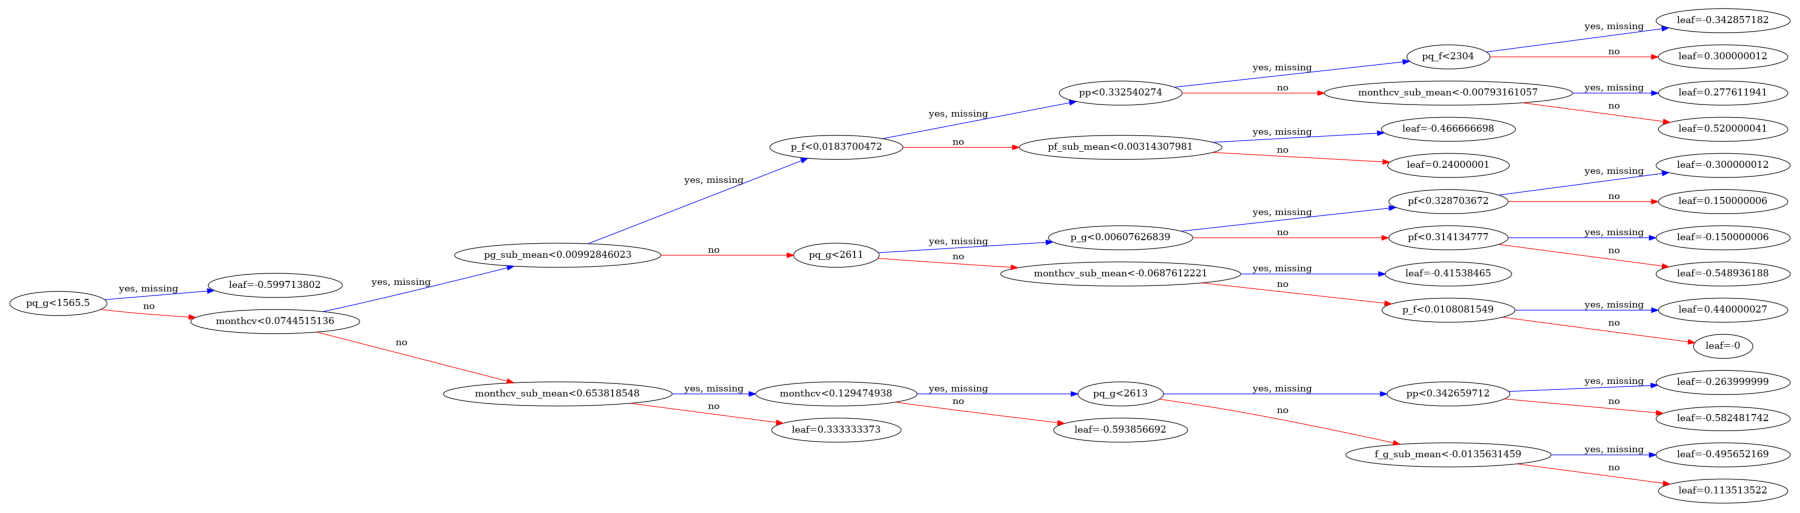

In [34]:
from xgboost import plot_tree
df = monthjoin
# cols = [
#     'pq_f',
#     'pq_g',
#     'pq_p',
#     'pq_z',
#     'kwh_cal',
#     'kwh_pap_r2',
#     'kwh_pap_r3',
#     'kwh_pap_r4',
#     'pq_f_sub_mean',
#     'pq_g_sub_mean',
#     'pq_p_sub_mean',
#     'pq_z_sub_mean',
# ]
cols2 = ['monthcv_sub_mean',
         'p_f_sub_mean',
         'p_g_sub_mean',
         'f_g_sub_mean',
         'pf_sub_mean',
         'pg_sub_mean',
         'pp_sub_mean']
cols = [i for i in df.columns.values if 'pq_' in i or 'kwh_' in i] + cols2

# features = list(set(df.columns.values) - {'IS_FLAG', 'label'} - set(cols))
features = C.month_features + cols2
print(features)

x, x_val = df.loc[df.label != 'test', features], df.loc[df.label == 'test', features]
y = df.loc[df.label != 'test', 'IS_FLAG']

model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(x, y)
y_pred = model.predict(x)
print((y_pred != y).sum())
fig, ax = plt.subplots(figsize=(32, 16))
plot_tree(model, ax=ax, rankdir='LR')


In [35]:
pred = pd.DataFrame({'id': x.index.values, 'pred': y_pred.astype(int)}).groupby('id').sum()
pred[pred.pred > 0]


,pred
id,
329833811,22
1998335717,22
2294741747,22
2482675592,22
2614556942,22
2654985038,22
2674563661,22
2695447713,22
2816697143,22


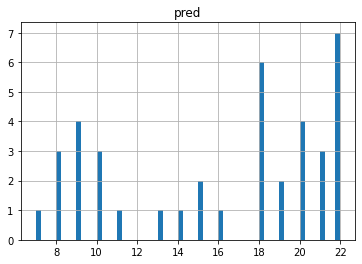

39
in s1 not s2 6
in s2 not s1 11
inner 28
0.6222222222222222


In [89]:
y_val = model.predict(x_val)
pred = pd.DataFrame({'id': x_val.index.values, 'pred': y_val}).groupby('id').sum()
pred = pred[pred.pred > 6]
pred.hist(bins=60)
plt.show()

submit(pred.index.unique(), 'submit_3_8_2.csv')
inner = diff('submit_3_7_1.csv', 'submit_3_8_2.csv')


In [90]:
inner = diff('submit_3_7_3.csv', 'submit_3_8_3.csv')


in s1 not s2 5
in s2 not s1 5
inner 22
0.6875
